In [1]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment

MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 714.45it/s]


In [2]:
from utils import Net
import torch.optim as optim
import torch.nn as nn

criterion = nn.NLLLoss()
optimizer = optim.Adam
optim_params = {"lr":0.001}
model = Net(MDP.S, MDP.A, MDP.d, criterion, optimizer,  optim_params, real_transitions=t)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
model.to(device)

In [5]:
import numpy as np
def reward(s_prev, a, s_next):
    return np.log(s_prev + 1) + np.log(a + 1) + np.log(s_next + 1)


In [6]:
def sherman_morrison(inverse, v):
    """
    Calculates the inverse of A + (v * v^t) using the sherman-morrison formula
    # Parameters:
    inverse: Previous inverse of size (n, n)
    v: Column vector of size (n, 1)
    """
    # print(inverse.shape, v.shape)
    w = inverse @ v

    return inverse - (w @ w.T)/(1 + np.dot(v.T, w))

def calc_inverse_cov(inverse, vectors: list[np.ndarray]):
    S = inverse.copy()
    for v in vectors:
        S = sherman_morrison(S, v)
    
    return S


In [7]:
n = 64
Jmax = 2000

In [8]:
%%time
from tqdm import tqdm
import random
from utils import ListDataset


data_set = []
losses = []

s_prev = 0
inv_covariance = np.eye(model.d)

with tqdm(range(Jmax)) as tepoch:
    for i in tepoch:

        # Take n Samples
        a = random.randint(0, (model.actions - 1))
        new_data = [(s_prev, a, MDP.next_step_state(s_prev, a))  for _ in range(n)]
        batch_data = random.choices(data_set, k=n) if i > 0 else []
        batch_data.extend(new_data) # Size 2n

        batch_size = len(batch_data) // 2

     

        # Get approximation of MLE
        running_loss = model.backward(ListDataset(batch_data, batch_size= batch_size))

        # Save metrics
        tepoch.set_postfix(loss=f'{running_loss / 10:.3f}')
        losses.append(running_loss)

        # Add all new data to old data
        data_set.extend(new_data) 

        # Planner for the next state
        with torch.no_grad():
            # Get vector for covariance matrix
            s1 = torch.tensor([new_data[i][0] for i in range(n // 2)])
            a1 = torch.tensor([new_data[i][1] for i in range(n // 2)])

            v = model.phi(s1, a1).detach().to("cpu").numpy().reshape(-1, model.d, 1)
            inv_covariance = calc_inverse_cov(inv_covariance, v)
            planner = model.rep_ucb_planner(reward, inv_covariance)
            a_next = planner(s_prev)
            s_prev = MDP.next_step_state(s_prev, a_next)

100%|██████████| 2000/2000 [08:20<00:00,  4.00it/s, loss=0.424]

CPU times: total: 46min 28s
Wall time: 8min 20s


In [9]:
from pickle import dump 

dump([model, losses], open('./data/models/repucb_lgbatch_jmax2000.bin', 'wb'))

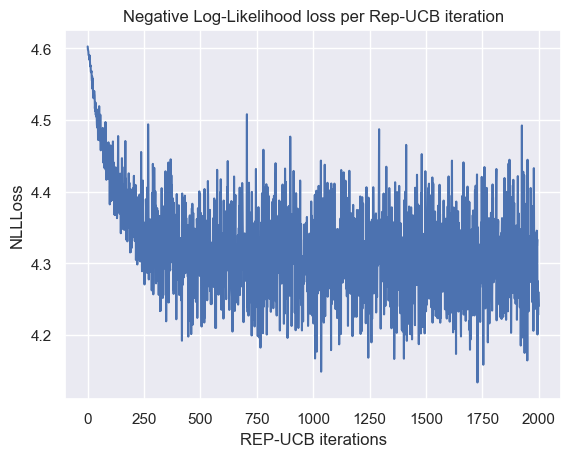

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.plot(losses)
plt.title("Negative Log-Likelihood loss per Rep-UCB iteration")
plt.xlabel("REP-UCB iterations")
plt.ylabel("NLLLoss")
plt.savefig("./images/small_mdp_repucb_lgbatch_lgjmax_jmax2000_losses.pdf",format="pdf", bbox_inches="tight")

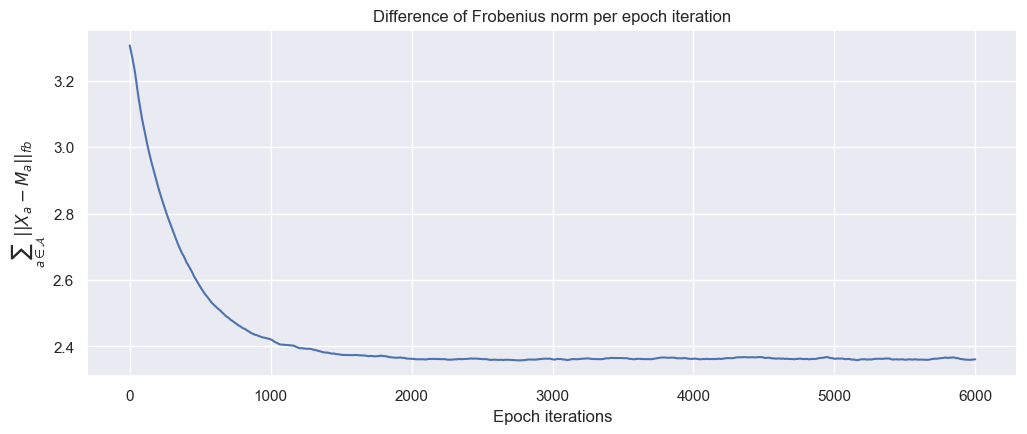

In [11]:
plt.figure(figsize=(12, 4.5))
plt.plot(model.frob_diff)
plt.title("Difference of Frobenius norm per epoch iteration")
plt.xlabel("Epoch iterations")
plt.ylabel("$\sum_{a \in \mathcal{A}}||X_a - M_a||_{fb}$")
plt.savefig("./images/small_mdp_repucb_lgbatch_lgjmax_jmax2000_fb_diff.pdf",format="pdf", bbox_inches="tight")

Optimal Value Function and Policy

In [13]:
%%time
from utils import PolicyIteration

def next_state_prob(s, a):
            with torch.no_grad():
                return model.forward(torch.from_numpy(s.ravel()).to(model.device).long(), 
                                    torch.from_numpy(a.ravel()).to(model.device).long()).to("cpu").numpy()

pol_iter = PolicyIteration(model.states , model.actions, next_state_prob , reward)

v, pol = pol_iter.run()



  0%|          | 1/2000 [00:00<00:11, 167.75it/s]

CPU times: total: 31.2 ms
Wall time: 29.5 ms


In [16]:
from pickle import load

v_true, pol_true = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_optimals.bin"), 'rb'))

np.mean(np.abs(v - v_true))



0.03392716387629718

In [18]:
import torch.nn.functional as F
s_arr = np.arange(MDP.S)
s = np.repeat(s_arr, [MDP.A] * MDP.S)
s_t = torch.tensor(s.ravel()).to(device).to(torch.int64)
print(s_t.dtype)
input_len = len(s_t) if hasattr(s_t, '__len__') else 1
s_hot = F.one_hot(s_t.view(input_len, 1), MDP.S)


torch.int64


In [16]:
w = inv_covariance @ v
np.dot(v.T, w)

array([[0.34073643]])

In [14]:
I = np.arange(9).reshape(3,3)
v = np.arange(15).reshape(5, 3, 1)

(np.transpose(v, axes=(0, 2, 1)) @ I @ v).shape

(5, 1, 1)

In [2]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment, ValueIteration, PolicyEvaluation, DeterministicPolicy

MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 1999.29it/s]


In [3]:
policy = DeterministicPolicy(MDP.S, MDP.A)

In [3]:
def next_state_prob(s, a):
    return MDP.Phi(s, a) @ MDP.U.T

In [5]:
pol_eval = PolicyEvaluation(MDP.S, MDP.A, policy.get_action ,  next_state_prob, reward)

In [6]:
_, _, V = pol_eval.evaluatePolicy()
V.shape

(100,)

In [7]:
s_l = MDP.S
a_l = MDP.A
s_arr = np.arange(s_l)
a_arr = np.arange(a_l)
s1_probs = np.repeat(s_arr, [a_l] * s_l)
a1_probs = np.tile(a_arr, s_l)
probs = next_state_prob(s1_probs, a1_probs).reshape(s_l, -1, s_l)
probs.shape

(100, 10, 100)

In [38]:
s1 = np.repeat(s_arr, [s_l * a_l] * s_l).reshape(s_l, -1, s_l)
a1 = np.tile(np.repeat(a_arr, [s_l]*a_l), s_l).reshape(s_l, -1, s_l)
s2 = np.tile(s_arr, s_l * a_l).reshape(s_l, -1, s_l)
V_index = V[s2]
R = reward(s1, a1, s2)
print(R.shape)
print(V_index.shape)

(100, 10, 100)
(100, 10, 100)


In [39]:
Pi = probs * (R + 0.5 * V_index)
Pi.shape

(100, 10, 100)

In [46]:
np.sum(Pi[10,2,:])

11.53700323310986

In [54]:
Pi_sum = np.sum(Pi, axis=-1)
print(Pi_sum.shape)
Pi_sum[0,:]

(100, 10)


array([ 8.08994134,  8.76168189,  9.12857785,  9.47118265,  9.56107555,
        9.9167095 ,  9.93324912, 10.0529429 , 10.19515368, 10.3950744 ])

In [58]:
print(np.sum(Pi[0,:,:], axis=-1)[2])

print(np.argmax(np.sum(Pi[55,:,:], axis=-1)))

9.128577853711166
8


In [59]:
Pi_max = np.argmax(Pi_sum, axis = -1)
Pi_max[55]

8

In [7]:
# Final policy improvement
s_l = MDP.S
a_l = MDP.A
s_arr = np.arange(s_l)
a_arr = np.arange(a_l)
s1_probs = np.repeat(s_arr, [a_l] * s_l)
a1_probs = np.tile(a_arr, s_l)
probs = next_state_prob(s1_probs, a1_probs).reshape(s_l, -1, s_l)

s1 = np.repeat(s_arr, [s_l * a_l] * s_l).reshape(s_l, -1, s_l)
a1 = np.tile(np.repeat(a_arr, [s_l]*a_l), s_l).reshape(s_l, -1, s_l)
s2 = np.tile(s_arr, s_l * a_l).reshape(s_l, -1, s_l)
V_index = V[s2]
R = reward(s1, a1, s2)

Pi = probs * (R + 0.5 * V_index)
Pi_sum = np.sum(Pi, axis=-1)


optimal_policy = np.argmax(Pi_sum, axis = -1)
optimal_policy

array([9, 9, 9, 9, 7, 9, 9, 8, 9, 9, 9, 9, 8, 9, 8, 9, 9, 8, 8, 9, 9, 9,
       9, 8, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 8, 9, 8, 9, 9,
       9, 9, 9, 8, 9, 9, 9, 9, 9, 8, 9, 8, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9,
       9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int64)

In [8]:
from tqdm import tqdm
opti = np.zeros(MDP.S)

for s in tqdm(range(MDP.S)):
    max_a_sum = 0
    max_a_index = 0

    for a in range(MDP.A):
        a_sum = 0

        for s_ in range(MDP.S):
            p = MDP.T(s, a, s_)
            r = reward(s, a, s_)
            v = V[s_]
            a_sum += (p * (r + 0.5 * v))
        if a_sum >= max_a_sum:
            max_a_sum = a_sum
            max_a_index = a
    

    opti[s] = max_a_index


print(opti)



100%|██████████| 100/100 [00:00<00:00, 123.20it/s]

[9. 9. 9. 9. 7. 9. 9. 8. 9. 9. 9. 9. 8. 9. 8. 9. 9. 8. 8. 9. 9. 9. 9. 8.
 9. 9. 8. 8. 9. 9. 9. 9. 9. 9. 9. 9. 9. 8. 9. 8. 9. 8. 9. 9. 9. 9. 9. 8.
 9. 9. 9. 9. 9. 8. 9. 8. 9. 9. 9. 8. 9. 9. 9. 9. 9. 9. 9. 8. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 8. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9.]


In [12]:
np.array_equal(opti, optimal_policy)

True

In [9]:
optimal_policy == opti

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [10]:
from utils import PolicyImprovement

pol_improve = PolicyImprovement(MDP.S, MDP.A, policy.get_action ,  next_state_prob, reward)
pol = pol_improve.improvePolicy(V)
pol == opti

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [4]:
from utils import PolicyIteration
pol_iter = PolicyIteration( MDP.S, MDP.A, next_state_prob , reward)

optimal_V, optimal_pol = pol_iter.run(200)
print(optimal_pol)

100%|██████████| 200/200 [00:00<00:00, 508.41it/s]

[9 9 9 9 9 9 9 8 9 9 9 9 8 9 8 9 9 9 9 9 9 9 9 8 9 9 9 8 9 9 9 9 9 9 9 9 9
 8 9 8 9 8 9 9 9 9 9 8 9 9 9 9 9 8 9 8 9 9 9 8 9 9 9 9 9 9 9 8 9 9 9 9 9 9
 9 9 9 9 9 8 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [8]:
print(optimal_V)

[ 7.75622849  8.017433    8.30936555  8.39639299  8.47081596  8.62335449
  8.68677801  8.74130075  8.76291168  8.82232977  8.86751214  8.94923553
  8.96774652  9.01391839  9.07597535  9.04699367  9.11815726  9.15897536
  9.20336493  9.17456359  9.30692111  9.32180783  9.32974633  9.31100359
  9.2858264   9.31507559  9.35196094  9.36605623  9.35250523  9.37814424
  9.43807491  9.51208224  9.49165039  9.52784283  9.44799268  9.53900044
  9.5008917   9.55809341  9.62118845  9.56819685  9.64329735  9.60571844
  9.64486084  9.6424438   9.60050228  9.62557173  9.62532663  9.65914662
  9.62698825  9.64963989  9.62875733  9.64616943  9.76146802  9.70623372
  9.67584673  9.71904039  9.79964729  9.71776754  9.72562945  9.75292546
  9.85026078  9.79550708  9.81904062  9.86819763  9.7783726   9.76667872
  9.88664751  9.83099923  9.81405177  9.89996324  9.87319529  9.88430133
  9.82172893  9.82294384  9.83036297  9.84730405  9.83883916  9.89476195
  9.94183743  9.87468793  9.86883522  9.97974784  9

In [7]:
%time
from tqdm import tqdm

for _ in tqdm(range(100 * 1000)):
    P, R, sol = pol_eval.evaluatePolicy(discount=0.5)

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 100000/100000 [01:15<00:00, 1331.41it/s]


In [21]:
reward(1, policy.get_action(1), 0)

2.6390573296152584

In [23]:
import scipy
PRs = np.sum(P * R, axis = -1)
M = P - np.eye(MDP.S)
sol = scipy.linalg.solve(M, -PRs)
x = ((M @ sol) + PRs)
sol


array([7.12543063, 7.47974275, 6.72229299, 7.63709582, 8.08158764,
       8.17803906, 8.10358926, 8.05078363, 8.3173903 , 8.17697374,
       8.47874054, 8.09699212, 8.57469253, 8.03822614, 8.35393093,
       8.09528522, 7.93827681, 8.77980323, 8.50449494, 8.76181533,
       8.9152757 , 8.28768827, 8.61658011, 8.09557882, 8.20206625,
       8.68417552, 8.83233009, 8.98372286, 8.15325142, 8.82579003,
       8.93505601, 8.77392531, 9.09743714, 8.62523742, 9.03668887,
       8.99500762, 9.00719702, 9.16326006, 8.82909921, 8.0940744 ,
       9.17394173, 8.06054467, 8.39165139, 8.9819997 , 8.14852179,
       9.23231438, 9.11289168, 9.05776401, 8.77587606, 9.01255768,
       8.48887037, 8.88094716, 9.36709391, 8.87780964, 8.85585332,
       8.69218868, 9.35614929, 9.22384298, 8.5314168 , 8.5212357 ,
       9.19310343, 9.34940499, 9.27920308, 8.59107348, 9.03653916,
       9.35130166, 9.11012761, 8.62199661, 9.40932594, 9.21987134,
       9.43783298, 9.00560638, 9.45819757, 9.39309518, 9.47371

In [24]:
np.linalg.cond(M)

2.528900845854403

In [44]:
x = ((M @ sol) + PRs)
x[0]

-10.487752611290933

In [4]:
from utils import ValueIteration
value_iter = ValueIteration(MDP.S, MDP.A, next_state_prob , reward)

In [12]:
%time
V, diffs = value_iter.run(max_iter=100)

(100, 10, 100) (100, 10, 100) (100, 10, 100)
(100, 10, 100)
Probs: (1000,) (1000,)


100%|██████████| 100/100 [00:00<00:00, 242.69it/s, shape=(100,)]


In [9]:
diffs

[10.534038992825494,
 9.6217507392395,
 9.540082211571114,
 9.537973671555442,
 9.537871720518758,
 9.53786656204597,
 9.537866309806816,
 9.537866297274775,
 9.537866296656759,
 9.537866296626177,
 9.5378662966247,
 9.537866296624628,
 9.537866296624642,
 9.537866296624657,
 9.537866296624685,
 9.537866296624685,
 9.537866296624685,
 9.537866296624713,
 9.537866296624713,
 9.537866296624685,
 9.537866296624685,
 9.537866296624713,
 9.537866296624685,
 9.537866296624685,
 9.537866296624685,
 9.537866296624685,
 9.537866296624742,
 9.53786629662477,
 9.537866296624827,
 9.53786629662477,
 9.53786629662477,
 9.53786629662477,
 9.53786629662477,
 9.537866296624827,
 9.53786629662477,
 9.537866296624827,
 9.53786629662477,
 9.53786629662477,
 9.537866296624827,
 9.53786629662477,
 9.537866296624827,
 9.537866296624827,
 9.537866296624827,
 9.537866296624827,
 9.537866296624827,
 9.537866296624827,
 9.537866296624827,
 9.537866296624827,
 9.537866296624884,
 9.537866296624827,
 9.5378662966

In [13]:
V

array([950.24519186, 950.70636934, 951.35398538, 951.48863561,
       951.72540862, 951.95910772, 952.076463  , 952.21380095,
       952.19259246, 952.31800916, 952.4050145 , 952.59662595,
       952.6548457 , 952.71750209, 952.89742436, 952.75818712,
       952.9302783 , 953.07939077, 953.17566811, 953.0251835 ,
       953.36662811, 953.39028364, 953.39637723, 953.3675097 ,
       953.24726596, 953.31384529, 953.45813477, 953.46246612,
       953.37544806, 953.43288138, 953.58445711, 953.7731124 ,
       953.70648729, 953.79405379, 953.61943937, 953.80911353,
       953.69217412, 953.8740498 , 953.99840593, 953.88339573,
       954.04067256, 953.96761436, 954.0278418 , 954.01368357,
       953.92460324, 953.95141238, 953.94412965, 954.06492758,
       953.93409601, 953.98749708, 953.92877389, 953.96511916,
       954.26963525, 954.15079735, 954.05408842, 954.17251472,
       954.34744499, 954.12028138, 954.13440402, 954.24004014,
       954.46040005, 954.30690207, 954.36421524, 954.49

In [11]:
V

array([95375.12152857, 95375.58270605, 95376.23032209, 95376.36497232,
       95376.60174532, 95376.83544442, 95376.95279971, 95377.09013766,
       95377.06892917, 95377.19434587, 95377.28135121, 95377.47296266,
       95377.53118241, 95377.5938388 , 95377.77376107, 95377.63452383,
       95377.80661501, 95377.95572748, 95378.05200482, 95377.90152021,
       95378.24296481, 95378.26662035, 95378.27271394, 95378.24384641,
       95378.12360267, 95378.190182  , 95378.33447148, 95378.33880283,
       95378.25178477, 95378.30921809, 95378.46079381, 95378.64944911,
       95378.582824  , 95378.6703905 , 95378.49577608, 95378.68545024,
       95378.56851083, 95378.75038651, 95378.87474264, 95378.75973244,
       95378.91700927, 95378.84395107, 95378.90417851, 95378.89002028,
       95378.80093995, 95378.82774909, 95378.82046636, 95378.94126429,
       95378.81043272, 95378.86383379, 95378.8051106 , 95378.84145586,
       95379.14597196, 95379.02713406, 95378.93042513, 95379.04885143,
      

Text(0.5, 0, 'Iterations')

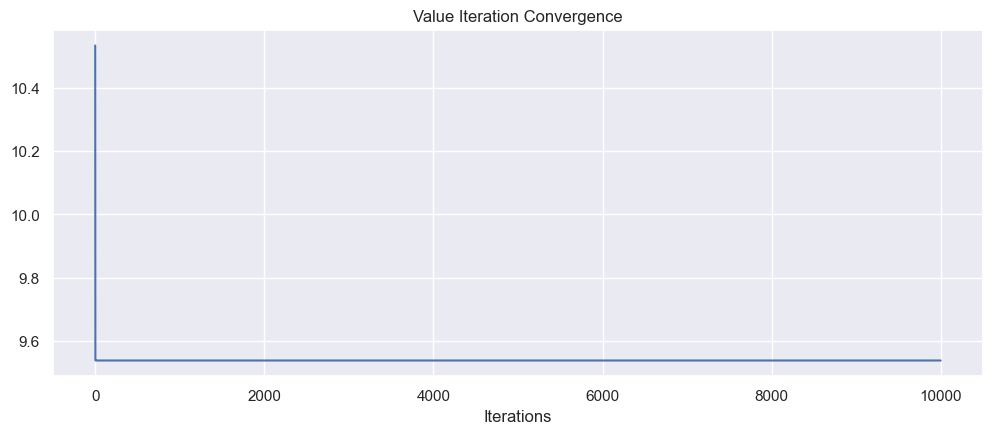

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.figure(figsize=(12, 4.5))
plt.plot(diffs)
plt.title("Value Iteration Convergence")
plt.xlabel("Iterations")